**Importing all the necessary libraries**

In [2]:
from sklearn.metrics import confusion_matrix
import keras
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from load_data import *

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Loading the dataset**

In [0]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = load_dataset()

The next cell will show you an example of a labelled image in the dataset. Feel free to change the value of index below and re-run to see different examples.

y =  0


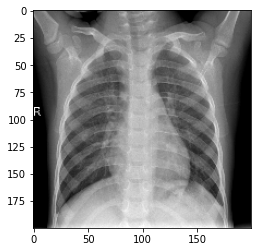

In [18]:
index = 8
print('y = ', str(np.squeeze(Y_train[index])))
plt.imshow(X_train[index])

**Normalizing the input data**

In [0]:
X_train, X_val, X_test = X_train/255, X_val/255, X_test/255

Let's examine the shapes of the data

In [6]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_val shape: " + str(X_val.shape))
print ("Y_val shape: " + str(Y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 4775
number of validation examples = 457
number of test examples = 624
X_train shape: (4775, 200, 200, 3)
Y_train shape: (4775, 1)
X_val shape: (457, 200, 200, 3)
Y_val shape: (457, 1)
X_test shape: (624, 200, 200, 3)
Y_test shape: (624, 1)


**Create the model**

In [0]:
model = Sequential(name='Sequential_model')

model.add(Conv2D(input_shape=(200,200,3),filters=16,kernel_size=(3,3),padding="same"))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=32,kernel_size=(3,3),padding="same"))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=32,kernel_size=(3,3),padding="same"))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(units=4096))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(units=2096))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(units=2096))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1, activation="sigmoid"))

**Compile the model**

In [0]:
opt = Adam(lr=0.0004)
model.compile(optimizer=opt, loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

**Train the model**

In [0]:
model.fit(X_train, Y_train, epochs=4, batch_size=64)

I have trained this model and saved the weights. So I am going to load the pre-trained weights that gave me the best results.

In [0]:
model.load_weights('best_weights.h5')

**Evaluate the model**

Performance on **Validation Set**

In [19]:
eval_val = model.evaluate(X_val, Y_val)
print ("Loss = " + str(eval_val[0]))
print ("Validation Set Accuracy = " + str(eval_val[1]))

457/457 [==============================] - 6s 14ms/step
Loss = 0.1359296972563804
Validation Set Accuracy = 0.9518599510192871


Performance on **Test Set**

In [20]:
eval_test = model.evaluate(X_test, Y_test)
print ("Loss = " + str(eval_test[0]))
print ("Test Set Accuracy = " + str(eval_test[1]))

624/624 [==============================] - 8s 13ms/step
Loss = 0.3560644873441794
Test Set Accuracy = 0.9038461446762085


So, I've got **95% accuracy on Validation set** and **90% accuracy on Test Set**. But the data that I had for training was imbalanced that is, I had around 1100 chest X-ray images of normal persons and 3500 chest X-ray images of persons having pneumonia. So, we want some other measure of accuracy that is, f1 score, precision and recall. 

Dataset Source : Kaggle

Define a threshold to classify images

In [0]:
threshold = 0.5

Predict the values in validation set

In [22]:
pred_val = model.predict(X_val, batch_size=64, verbose=1)
pred_val = (pred_val >= threshold).astype(int)

457/457 [==============================] - 6s 13ms/step


Predict the values in Test set

In [23]:
pred_test = model.predict(X_test, batch_size=64, verbose=1)
pred_test = (pred_test >= threshold).astype(int)

624/624 [==============================] - 8s 12ms/step


**Confusion Matrix**

In [0]:
def confusion_mtrx(true_labels, predicted_labels):
    cm = confusion_matrix(true_labels, predicted_labels)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='d')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix') 
    ax.xaxis.set_ticklabels(['Normal', 'Pneumonia'])
    ax.yaxis.set_ticklabels(['Normal', 'Pneumonia'])
    return cm

Calculating Precision, Recall and f1 score

In [0]:
def accuracy_measures(cm):
    TP = cm[1][1]
    TN = cm[0][0]
    FP = cm[1][0]
    FN = cm[0][1]
    P = TP/(TP + FN)
    R = TP/(TP + FP)
    print('Recall : ', R)
    print('Precision : ', P)
    print("F1 score : ", (2*P*R)/(P+R))

**Plot confusion matrix for validation set**

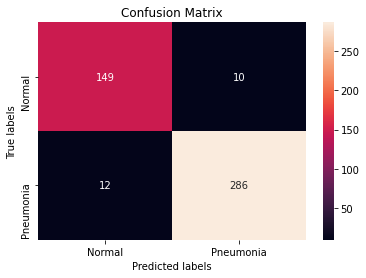

In [26]:
cm_val = confusion_mtrx(Y_val, pred_val)

Accuracy measure for **Validation set**

In [27]:
accuracy_measures(cm_val)

Recall :  0.959731543624161
Precision :  0.9662162162162162
F1 score :  0.962962962962963


**Plot confusion matrix for Test Set**

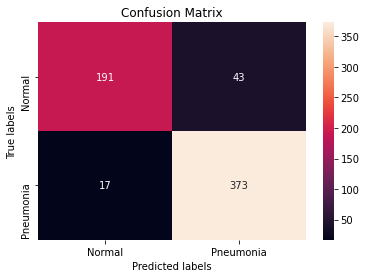

In [28]:
cm_test = confusion_mtrx(Y_test, pred_test)

Accuracy measure for **Test Set**

In [29]:
accuracy_measures(cm_test)

Recall :  0.9564102564102565
Precision :  0.8966346153846154
F1 score :  0.9255583126550868


As you can see that I've got around **96% Recall** and **90% Precision** and **92% f1 score**. Generally, in these kind of situations we want a higher **Recall** value.

**Summary of the Model**

In [32]:
model.summary()

Model: "Sequential_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 200, 200, 16)      448       
_________________________________________________________________
activation_11 (Activation)   (None, 200, 200, 16)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
activation_12 (Activation)   (None, 100, 100, 32)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 50, 50, 32)   